In [189]:
import matplotlib.pyplot as plt
import pandas as pd
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
from sqlalchemy import create_engine
import io
import datetime as dt
import numpy 

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)
    

In [8]:
string = '''WITH vols as (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
                    WHERE classification_uid in (1,4, 5)
                    AND intersection_uid = 1
                    AND leg = 'E' AND dir = 'EB'
                    AND extract(dow from datetime_bin) in (1,2,3,4,5)
                GROUP BY datetime_bin
                ORDER BY datetime_bin)


                SELECT vols.datetime_bin, volume FROM vols
                INNER JOIN 
                (SELECT datetime_bin::date
                    FROM vols
                    GROUP BY datetime_bin::date
                    HAVING count(volume) = 96) counts
                ON counts.datetime_bin::date = vols.datetime_bin::date
                ORDER BY vols.datetime_bin;'''

df = pandasql.read_sql(pg.SQL(string), con)
df['date'] = [d.date() for d in df['datetime_bin']]
df['timestamp'] = [d.time() for d in df['datetime_bin']]
df = df.drop(['datetime_bin'], axis=1)
column_order = ["date", "timestamp", "volume"]
df = df.reindex_axis(column_order, axis=1)

df.head(10)

,date,timestamp,volume
0,2017-10-12,00:00:00,44.0
1,2017-10-12,00:15:00,48.0
2,2017-10-12,00:30:00,48.0
3,2017-10-12,00:45:00,29.0
4,2017-10-12,01:00:00,36.0
5,2017-10-12,01:15:00,27.0
6,2017-10-12,01:30:00,18.0
7,2017-10-12,01:45:00,16.0
8,2017-10-12,02:00:00,25.0
9,2017-10-12,02:15:00,19.0


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


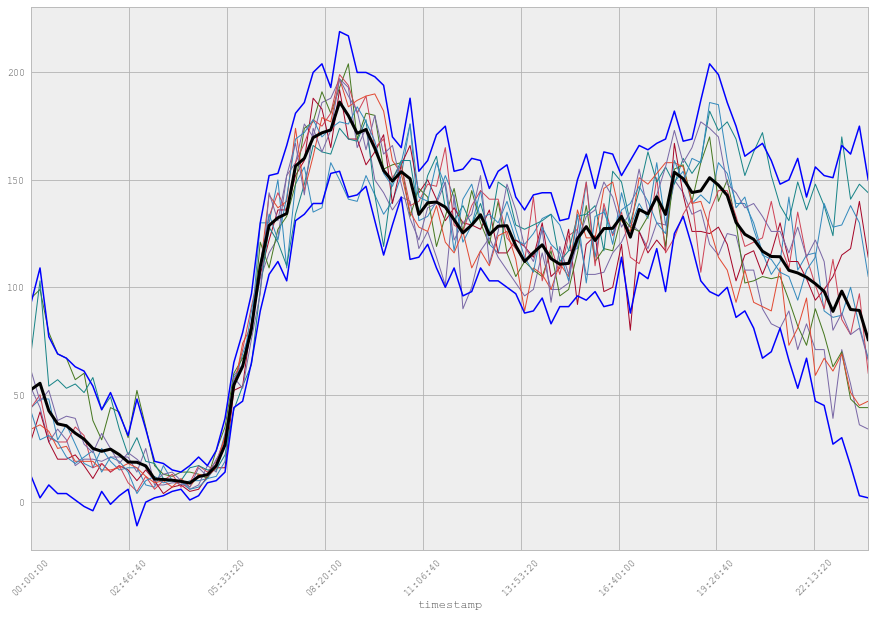

In [241]:
pd.options.display.mpl_style = 'default'


df.pivot_table(index=['timestamp'], columns=['date'], values=['volume']).plot(legend = None, rot = 45, figsize = (15, 10))
mean = pd.DataFrame(df.groupby('timestamp').mean()).reset_index()
std = pd.DataFrame(df.groupby('timestamp').std()).reset_index()
upper = pd.DataFrame(mean['volume'].add(2*std['volume']).apply(round, 1))
lower = pd.DataFrame(mean['volume'].add(-2*std['volume']).apply(round, 1))
times = pd.DataFrame(mean['timestamp'])


plt.plot(times, upper, linewidth = 1.5, color = 'blue')
plt.plot(times, lower, linewidth = 1.5, color = 'blue')

#plt.plot(times, lower)
plt.plot(times, mean['volume'], linewidth = 3, color = 'black')

#for i in range(len(times.values)):
#    plt.fill_between(times.values[i], lower.values[i], upper.values[i], color = 'red',alpha = 0.5,linewidth = 8)
plt.show()